# Quantum Memory Simulation - Particle Swarm Optimisation - ORCA + Rydberg


### Simulation Functions

In [1]:
%matplotlib inline

# Importing libraries

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
from tqdm.notebook import trange, tqdm
from IPython import display
import pylab as pl
import time
import pandas as pd

# Formatting plots and notebook outputs

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# Pulse Shape Functions

def exp_decay(t, t0, tau):
    """
    Exponential decay function.  Returns value at specified time.
    t0 = start time
    tau = characteristic 'decay' time - lifetime
    """
    A = np.sqrt(2/tau)
    if t < t0:
        return 0
    else:
        return A*np.exp(- (t-t0) / tau)

def gaussian(t, t0, tw, A):
    """
    Gaussian function. Returns value at specified time.
    tw = FWHM - pulse bandwidth is B = 0.44/tw - pulse duration t = 2.25*tw
    A = gaussian peak amplitude
    t0 = central time
    """
    sigma = tw/(2*np.sqrt(2*np.log(2)))
    gaussian = A*np.exp( - 0.5*((t-t0)/sigma)**2)
    return gaussian

def gaussianNorm(t, t0, tw):
    '''
    Gaussian funtion for the signal pulse. Input signal photon is a mode that must be normalised.
    '''
    sigma = tw/(2*np.sqrt(2*np.log(2)))
    amp = 1/(sigma*np.sqrt(2*np.pi))
    gaussian = amp*np.exp( - 0.5 * ((t-t0)/sigma)**2 )
    area = np.trapz(gaussian**2, t)
    gaussian = np.sqrt(L/c)*gaussian/np.sqrt(area)
    return gaussian


In [3]:
# Primary Simulation Functions

def init_coherences(Zlist, Tlist):
    '''
    Input the spatial grid z and the temporal grid t. Output the overall simulation matrices for
    the signal field, polarisation coherence, orbital-wave coherence and control field.
    '''
    #P = np.array([[0.0 for i in Zlist] for n in Tlist], dtype = "complex_")
    P = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    B = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    R = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    return P, B, R

def init_signal(Zlist, Tlist, shape, offset, pulsewidth):
    '''
    Input spatial grid z, temporal grid t and signal pulse-shape parameters. Output initial matrix
    for the signal field evolution.
    '''
    S = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    
    if shape == "zero":
        return S
    
    elif shape == "gaussian":
        S[:,0] = gaussianNorm(Tlist, offset, pulsewidth)
        return S

def init_control(initial, Zlist, Tlist, direction):
    '''
    Input spatial grid z, temporal grid t, and control pulse-shape parameters and direction. Output
    complete matrix for the control pulse evolution.
    '''
    if direction == "forward":
        Oc = np.array([initial[np.rint((t - tt0 - Zlist/c)/dt).astype(int)] for t in Tlist], dtype = "complex_")
        
    elif direction == "backward":
        Oc = np.array([initial[np.rint((t - tt0 + (Zlist-L)/c)/dt).astype(int)] for t in Tlist], dtype = "complex_")
        
    return Oc

def solve(S, P, B, R, Oc1, Oc2):
    '''
    Input signal field, polarisation coherence and orbital wave coherence matrices. Simulates storage process.
    Fourth order Runge-Kutta (RK4) in time. First order Euler backward in space.
    Output signal field, polarisation coherence and orbital wave coherence matrices after storage.
    '''
    for n in range(0, len(Tlist)-1):  
        S[n+1][1:] = (1-fo)*S[n][1:] + fo*S[n][:-1] + 1j*k*P[n][1:]*dt 
        
        p1 = P[n]
        p2 = P[n] + (dt/2)*p1
        p3 = P[n] + (dt/2)*p2
        p4 = P[n] + dt*p3
        P[n+1] = P[n] - (y2/2 - 1j*delta1)*(dt/6)*(p1 + 2*p2 + 2*p3 + p4) + 1j*k*S[n]*dt + 1j*Oc1[n]*B[n]*dt
        
        b1 = B[n]
        b2 = B[n] + (dt/2)*b1
        b3 = B[n] + (dt/2)*b2
        b4 = B[n] + dt*b3
        B[n+1] = B[n] - (y3/2 - 1j*delta2)*(dt/6)*(b1 + 2*b2 + 2*b3 + b4) + 1j*Oc1[n]*P[n]*dt + 1j*Oc2[n]*R[n]*dt
        
        r1 = R[n]
        r2 = R[n] + (dt/2)*r1
        r3 = R[n] + (dt/2)*r2
        r4 = R[n] + dt*r3
        R[n+1] = R[n] - (y4/2)*(dt/6)*(r1 + 2*r2 + 2*r3 + r4) + 1j*Oc2[n]*B[n]*dt
        
    return S, P, B, R

def calc_storage_efficiency(S, R):
    '''
    Check if the input signal field is normalised. Calculate the stored orbital-wave coherence and thus the
    storage efficiency.
    '''
    Sin = (c/L)*np.trapz(np.abs(S.transpose()[0])**2, Tlist)
    if round(Sin,3) != 1:
        return "Signal mode isn't normalised"
    else:
        Rout = (1/L)*np.trapz(np.abs(R[-1])**2, Zlist)
        return Rout

def init_retrieval(S, P, B, R, rev):
    '''
    Set coherences and signal field to zero. Set initial condition where the orbital-wave coherence is in the
    final state of the storage process.
    '''
    Sr = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    Pr = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    Br = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    Rr = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    if rev == 'reverse':  
        Rinit = R[-1][::-1]
        Rr[0] += Rinit
    elif rev == 'normal':
        Rinit = R[-1]
        Rr[0] += Rinit    
    return Sr, Pr, Br, Rr

def calc_total_efficiency(Sr, Rr):
    '''
    Calculate the energy in the output photonic mode (signal field). Since the input signal field is
    normalised, this output signal field represents the total memory efficiency. (Gorshkov)
    '''
    time_bin = int(round(2.25*tws/dt))
    Sout = (c/L)*np.trapz(np.abs(Sr.transpose()[-1][:time_bin])**2, Tlist[:time_bin])
    return Sout

def calc_overlap(control, signal):
    '''
    Used for pulse shaping, calculating the overlap between input and output signal pulses.
    '''
    overlap = np.array([min(control[n], signal[n]) for n in range(0,len(Tlist))])
    overlap_factor = np.trapz(overlap, Tlist)/np.trapz(signal, Tlist)
    return overlap_factor


#### Define simulation parameters - domain and discretisation

In [4]:
# SIMULATION PARAMETERS 

c = 300 # speed of light mm per ns

# TEMPORAL DOMAIN - ns
T0 = 0.0; T = 2.; tsteps = 2500
Tlist = np.linspace(T0, T, tsteps); dt = Tlist[1]-Tlist[0]; print('dt ', dt)

# Pulse Shape Initialisation domain - ns
tt0 = -2.; tt = 2.; ttsteps = 2*tsteps
ttlist = np.linspace(tt0, tt, ttsteps); dtt = Tlist[1]-Tlist[0]; print('dtt ', dtt)

# SPATIAL DOMAIN - mm
L0 = 0.0; L = 100; zsteps = 400
Zlist = np.linspace(L0, L, zsteps); dz = Zlist[1]-Zlist[0]; print('dz ', dz)

# Fourier number - stability check
fo = c*dt/dz; print('Fourier Number: ', fo)

dt  0.0008003201280512205
dtt  0.0008003201280512205
dz  0.2506265664160401
Fourier Number:  0.9579831932773111


#### Define atomic system parameters - detuning, decoherence rates, coupling strengths

In [5]:
# SYSTEM PARAMETERS 

delta1 = 6 # detuning - GHz
delta2 = 0

y2 = 1/29  # polarisation decoherence - GHz - 0.0328
y3 = 1/86  # orbital wave decoherence
y4 = 1/270 # GHz

d = 5000  # optical depth
k = np.sqrt((d*y2*c)/(2*L))  # coupling constant

#### Initialise atomic coherences and signal photon

In [21]:
P, B, R = init_coherences(Zlist, Tlist)  # initialise coherences 

tws = 0.440; t0s = 2.25*tws/2
S = init_signal(Zlist, Tlist, 'gaussian', t0s, tws)  # initialise signal field

## Particle Swarm Optimisation - Gaussian

### STORAGE

#### Define optimisation hyper-parameters

In [22]:
pop = 12 # How many particles 
iterations = 200
Oc_max = 3*np.pi  # Max control Rabi frequency
w = 0.7  # Inertia
c1 = 2.5  # Cognitive
c2 = 2.4  # Social

#### Run particle swarm optimisation algorithm

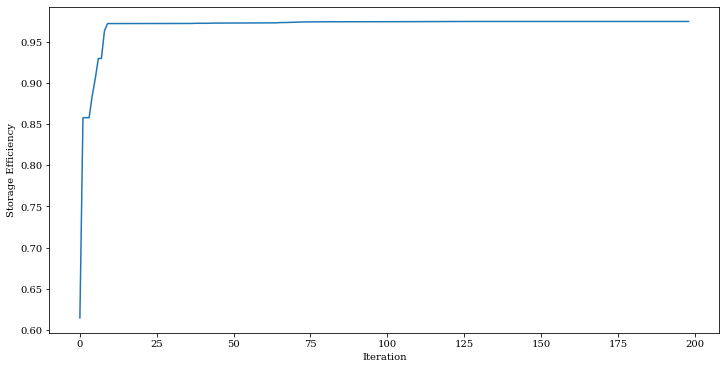

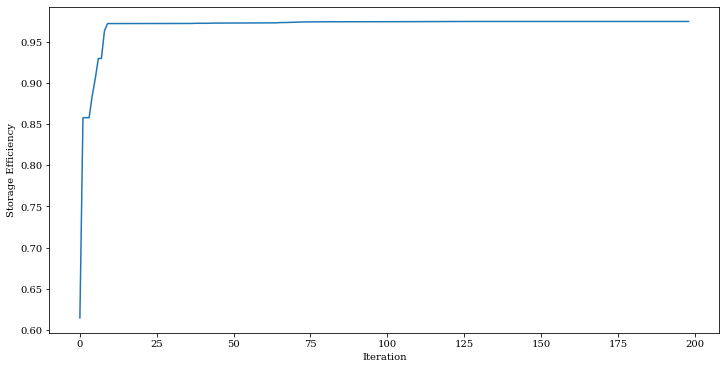

In [23]:
particles = np.array([[[np.zeros(6), np.zeros(6), 0.] for n in range(iterations)] for p in range(pop)], dtype = 'object')
for particle in particles:
    particle[0][0] = [np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max, np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max]
    particle[0][1] = np.random.rand(6)

alphas = []  # Track global efficiency
alphas_positions = []  # Track best parameters
fig = plt.figure()  # Prepare live plotting
ax = fig.add_subplot(1,1,1)

for n in range(iterations-1):
    
    w = 0.8 - (0.6/iterations)*n
    c1 = -3*n/iterations + 3.5
    c2 = 3*n/iterations + 0.5
    
    global_bests = np.array([[[0., 0., 0.], 0.] for p in range(pop)], dtype = 'object')
    for p in range(pop):
        # compute fitness of each particle in this iteration
        particles[p][n][0][2] = np.clip(particles[p][n][0][2], 0, Oc_max)
        particles[p][n][0][5] = np.clip(particles[p][n][0][5], 0, Oc_max)
        
        Oc1_init = gaussian(ttlist, particles[p][n][0][0], particles[p][n][0][1], particles[p][n][0][2])
        Oc2_init = gaussian(ttlist, particles[p][n][0][3], particles[p][n][0][4], particles[p][n][0][5])
        
        Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
        Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')
        
        S, P, B, R = solve(S, P, B, R, Oc1, Oc2)
        particles[p][n][2] = calc_storage_efficiency(S,R)
        
        # for each particle find its best position
        individual_max_indx = np.argmax(particles[p,:,2])
        particle_best = particles[p][individual_max_indx][2]
        particle_best_position = particles[p][individual_max_indx][0]
        # assign to global bests
        global_bests[p][0] = particle_best_position
        global_bests[p][1] = particle_best
    # find the global best and the corresponding position
    global_max_indx = np.argmax(global_bests[:,1])
    global_best = global_bests[global_max_indx, 1]
    global_best_position = global_bests[global_max_indx, 0]
    alphas.append(global_best)
    alphas_positions.append(global_best_position)
    # update plot
    pl.clf()
    pl.plot(range(0,n+1), alphas, 'C0')
    pl.xlabel('Iteration')
    pl.ylabel('Storage Efficiency')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    for p in range(pop):
        # Compute next iteration
        particles[p][n+1][1] = w*np.array(particles[p][n][1]) + c1*np.random.rand()*(np.array(global_bests[p][0]) - np.array(particles[p][n][0])) + c2*np.random.rand()*(np.array(global_best_position) - np.array(particles[p][n][0]))
        particles[p][n+1][0] = np.clip(particles[p][n][0] + particles[p][n+1][1], 0.1, None)
        

### RETRIEVAL

#### Prepare input to retrieval simulation

In [30]:
g_params = alphas_positions[-1]

Oc1_init = gaussian(ttlist, g_params[0], g_params[1], g_params[2])
Oc2_init = gaussian(ttlist, g_params[3], g_params[4], g_params[5])

Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

S,P,B,R = solve(S,P,B,R,Oc1,Oc2)

#### Define retrieval optimisation hyper-parameters

In [31]:
pop = 12 # How many particles 
iterations = 400

Ocr_max = 3*np.pi  # Max control Rabi frequency
w = 0.7  # Inertia
c1 = 2.5  # Cognitive
c2 = 2.4  # Social

#### Run retrieval particle swarm optimisation algorithm

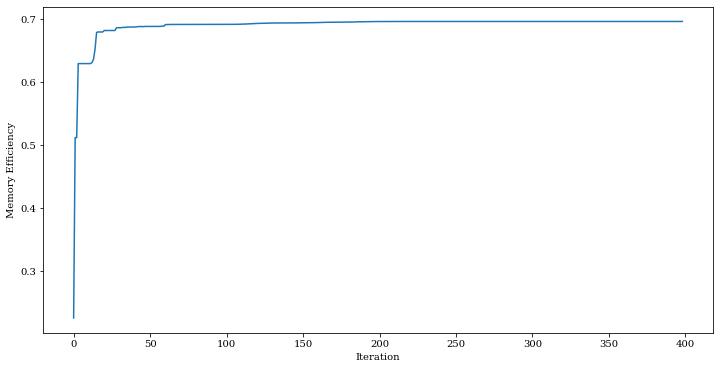

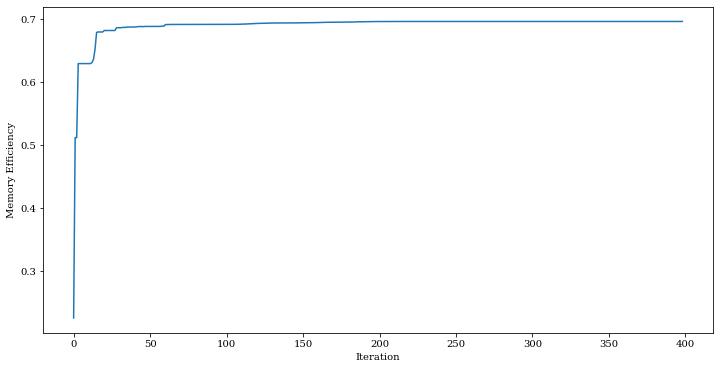

In [32]:
# particles[individual][iteration][position, velocity, fitness]

particles = np.array([[[np.zeros(6), np.zeros(6), 0.] for n in range(iterations)] for p in range(pop)], dtype = 'object')
for particle in particles:
    particle[0][0] = [np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max, np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max]
    particle[0][1] = np.random.rand(6)

alphasr = []  # Track global efficiency
alphas_positionsr = []  # Track best parameters
fig = plt.figure()  # Prepare live plotting
ax = fig.add_subplot(1,1,1)

for n in range(iterations-1):
    
    w = 0.8 - (0.6/iterations)*n
    c1 = -3*n/iterations + 3.5
    c2 = 3*n/iterations + 0.5
    
    global_bests = np.array([[[0., 0., 0.], 0.] for p in range(pop)], dtype = 'object')
    for p in range(pop):
        # compute fitness of each particle in this iteration
        particles[p][n][0][2] = np.clip(particles[p][n][0][2], 0, Ocr_max)
        particles[p][n][0][5] = np.clip(particles[p][n][0][5], 0, Ocr_max)
        
        Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'reverse')
        
        Oc1_init = gaussian(ttlist, particles[p][n][0][0], particles[p][n][0][1], particles[p][n][0][2])
        Oc2_init = gaussian(ttlist, particles[p][n][0][3], particles[p][n][0][4], particles[p][n][0][5])
        
        Ocr1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
        Ocr2 = init_control(Oc2_init, Zlist, Tlist, 'backward')
        
        Sr, Pr, Br, Rr = solve(Sr, Pr, Br, Rr, Ocr1, Ocr2)
        particles[p][n][2] = calc_total_efficiency(Sr,Rr)*calc_overlap(np.abs(Sr.transpose()[-1])**2, np.abs(S.transpose()[0])**2)
        
        # for each particle find its best position
        individual_max_indx = np.argmax(particles[p,:,2])
        particle_best = particles[p][individual_max_indx][2]
        particle_best_position = particles[p][individual_max_indx][0]
        # assign to global bests
        global_bests[p][0] = particle_best_position
        global_bests[p][1] = particle_best
    # find the global best and the corresponding position
    global_max_indx = np.argmax(global_bests[:,1])
    global_best = global_bests[global_max_indx, 1]
    global_best_position = global_bests[global_max_indx, 0]
    alphasr.append(global_best)
    alphas_positionsr.append(global_best_position)
    # update plot
    pl.clf()
    pl.plot(range(0,n+1), alphasr, 'C0')
    pl.xlabel('Iteration')
    pl.ylabel('Memory Efficiency')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    for p in range(pop):
        # Compute next iteration
        particles[p][n+1][1] = w*np.array(particles[p][n][1]) + c1*np.random.rand()*(np.array(global_bests[p][0]) - np.array(particles[p][n][0])) + c2*np.random.rand()*(np.array(global_best_position) - np.array(particles[p][n][0]))
        particles[p][n+1][0] = np.clip(particles[p][n][0] + particles[p][n+1][1], 0.1, None)
        

## Checking the Results

### Storage - Control Pulse and Storage Efficiency

Storage Efficiency:  0.9746944154138342


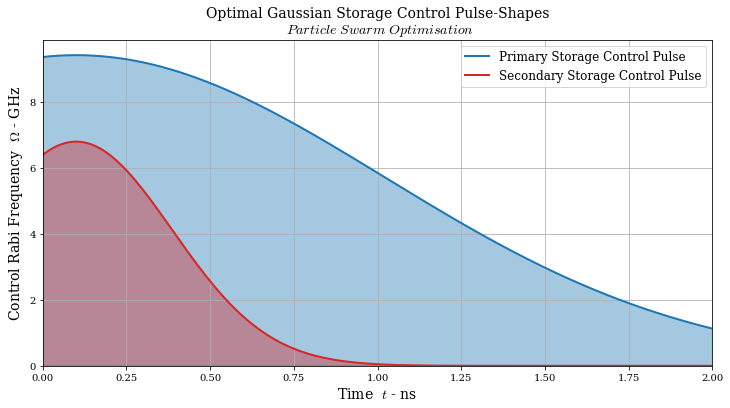

In [73]:
g_params = alphas_positions[-1]
Oc1_init = np.array([gaussian(t, g_params[0], g_params[1], g_params[2]) for t in ttlist])
Oc2_init = np.array([gaussian(t, g_params[3], g_params[4], g_params[5]) for t in ttlist])

plt.plot(ttlist, Oc1_init, linewidth = 2, color='C0', label = "Primary Storage Control Pulse")
plt.fill_between(ttlist, Oc1_init, color="C0", alpha=0.4)
plt.plot(ttlist, Oc2_init, linewidth = 2, color='C3', label = "Secondary Storage Control Pulse")
plt.fill_between(ttlist, Oc2_init, color="C3", alpha=0.4)
plt.xlim([0,2])
plt.ylim([0, None])
plt.xlabel("Time  $t$ - ns", fontsize = 14)
plt.ylabel("Control Rabi Frequency  $\Omega$ - GHz", fontsize = 14)
plt.legend(fontsize=12)
plt.title("Optimal Gaussian Storage Control Pulse-Shapes\n $Particle \ Swarm \ Optimisation$", fontsize = 14)
plt.grid()

Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

S,P,B,R = solve(S,P,B,R,Oc1,Oc2)

eff = calc_storage_efficiency(S,R)
print("Storage Efficiency: ", eff)

plt.savefig("pso-gauss-storage-pulses.png", dpi=1200)

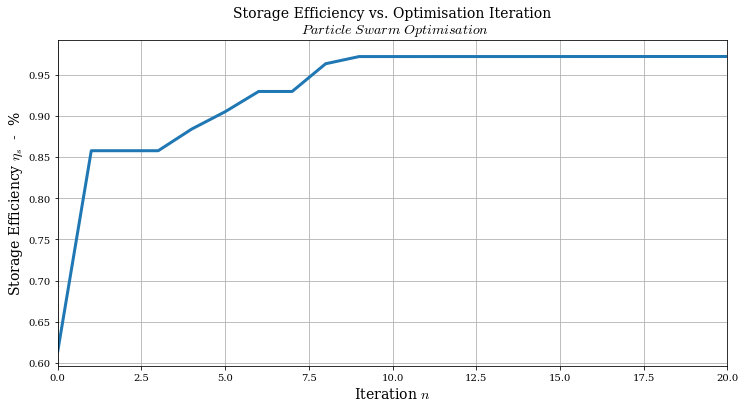

In [66]:
plt.plot(range(0,199), alphas, 'C0', linewidth =3)
plt.xlim([0, 20])
plt.xlabel("Iteration $n$", fontsize=14)
plt.ylabel("Storage Efficiency $\eta_s$  -  %", fontsize = 14)
plt.title("Storage Efficiency vs. Optimisation Iteration\n $Particle \ Swarm \ Optimisation$", fontsize =14)
plt.grid()

#plt.savefig("pso-gauss-storage-track.png", dpi=1200)

### Retrieval - Control Pulse and Memory Efficiency

Total Memory Efficiency:  0.8945031592922945


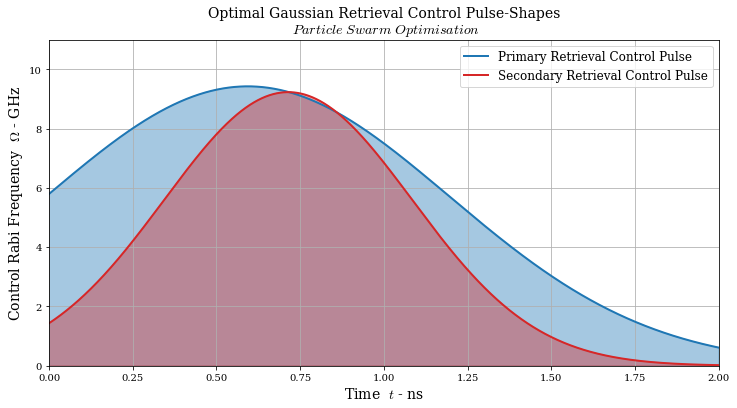

In [75]:
g_params = alphas_positionsr[-1]
Oc1_init = np.array([gaussian(t, g_params[0], g_params[1], g_params[2]) for t in ttlist])
Oc2_init = np.array([gaussian(t, g_params[3], g_params[4], g_params[5]) for t in ttlist])

plt.plot(ttlist, Oc1_init, linewidth = 2, color='C0', label = "Primary Retrieval Control Pulse")
plt.fill_between(ttlist, Oc1_init, color="C0", alpha=0.4)
plt.plot(ttlist, Oc2_init, linewidth = 2, color='C3', label = "Secondary Retrieval Control Pulse")
plt.fill_between(ttlist, Oc2_init, color="C3", alpha=0.4)
plt.xlim([0,2])
plt.ylim([0, 11])
plt.xlabel("Time  $t$ - ns", fontsize = 14)
plt.ylabel("Control Rabi Frequency  $\Omega$ - GHz", fontsize = 14)
plt.title("Optimal Gaussian Retrieval Control Pulse-Shapes\n $Particle \ Swarm \ Optimisation$", fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()

Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'reverse')

Ocr1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Ocr2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

Sr,Pr,Br, Rr = solve(Sr,Pr,Br,Rr,Ocr1, Ocr2)

eff = calc_total_efficiency(Sr,Rr)
print("Total Memory Efficiency: ", eff)

plt.savefig("pso-gauss-retrieval-pulses.png", dpi=1200)

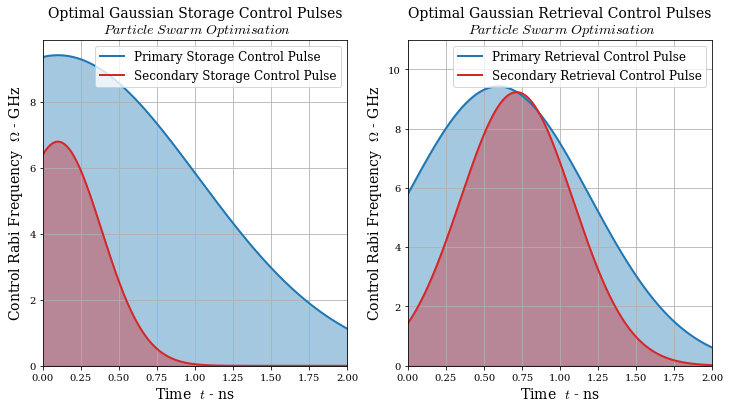

In [83]:
g_params = alphas_positions[-1]
Oc1_init = np.array([gaussian(t, g_params[0], g_params[1], g_params[2]) for t in ttlist])
Oc2_init = np.array([gaussian(t, g_params[3], g_params[4], g_params[5]) for t in ttlist])

g_params = alphas_positionsr[-1]
Oc1r_init = np.array([gaussian(t, g_params[0], g_params[1], g_params[2]) for t in ttlist])
Oc2r_init = np.array([gaussian(t, g_params[3], g_params[4], g_params[5]) for t in ttlist])

plt.subplot(1,2,1)
plt.plot(ttlist, Oc1_init, linewidth = 2, color='C0', label = "Primary Storage Control Pulse")
plt.fill_between(ttlist, Oc1_init, color="C0", alpha=0.4)
plt.plot(ttlist, Oc2_init, linewidth = 2, color='C3', label = "Secondary Storage Control Pulse")
plt.fill_between(ttlist, Oc2_init, color="C3", alpha=0.4)
plt.xlim([0,2])
plt.ylim([0, None])
plt.xlabel("Time  $t$ - ns", fontsize = 14)
plt.ylabel("Control Rabi Frequency  $\Omega$ - GHz", fontsize = 14)
plt.legend(fontsize=12)
plt.title("Optimal Gaussian Storage Control Pulses\n $Particle \ Swarm \ Optimisation$", fontsize = 14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(ttlist, Oc1r_init, linewidth = 2, color='C0', label = "Primary Retrieval Control Pulse")
plt.fill_between(ttlist, Oc1r_init, color="C0", alpha=0.4)
plt.plot(ttlist, Oc2r_init, linewidth = 2, color='C3', label = "Secondary Retrieval Control Pulse")
plt.fill_between(ttlist, Oc2r_init, color="C3", alpha=0.4)
plt.xlim([0,2])
plt.ylim([0, 11])
plt.xlabel("Time  $t$ - ns", fontsize = 14)
plt.ylabel("Control Rabi Frequency  $\Omega$ - GHz", fontsize = 14)
plt.title("Optimal Gaussian Retrieval Control Pulses\n $Particle \ Swarm \ Optimisation$", fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()

plt.savefig("pso-gauss-pulses.png",dpi=1200)


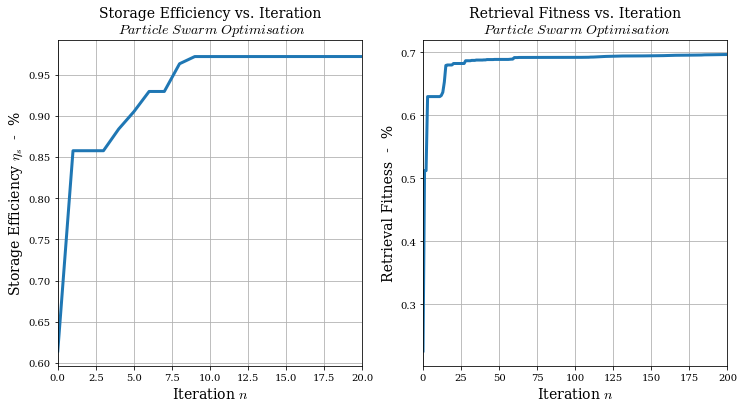

In [71]:
plt.subplot(1,2,2)
plt.plot(range(0,iterations-1), alphasr, 'C0', linewidth =3)
plt.xlim([0, 200])
plt.xlabel("Iteration $n$", fontsize=14)
plt.ylabel("Retrieval Fitness  -  %", fontsize = 14)
plt.title("Retrieval Fitness vs. Iteration\n $Particle \ Swarm \ Optimisation$", fontsize =14)
plt.grid()

plt.subplot(1,2,1)
plt.plot(range(0,199), alphas, 'C0', linewidth =3)
plt.xlim([0, 20])
plt.xlabel("Iteration $n$", fontsize=14)
plt.ylabel("Storage Efficiency $\eta_s$  -  %", fontsize = 14)
plt.title("Storage Efficiency vs. Iteration\n $Particle \ Swarm \ Optimisation$", fontsize =14)
plt.grid()

plt.savefig("pso-gauss-track.png",dpi=1200)

### Input and Output Signal Photon Comparison

0.7787494157849507


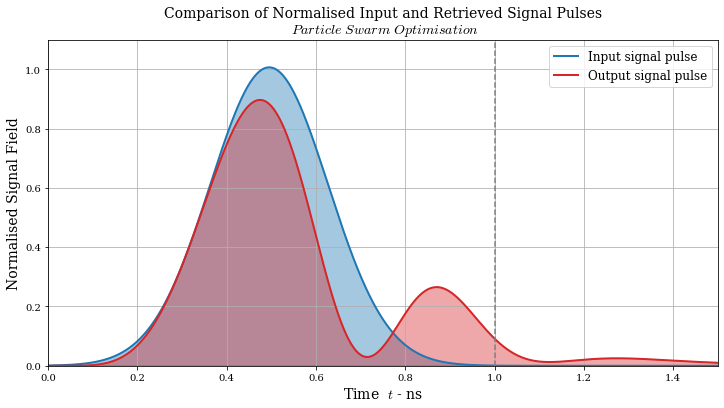

In [78]:
plt.plot(Tlist, np.abs(S.transpose()[0])**2, label="Input signal pulse", linewidth =2, color = "C0")
plt.fill_between(Tlist, np.abs(S.transpose()[0])**2, color="C0", alpha=0.4)
plt.plot(Tlist, np.abs(Sr.transpose()[-1])**2, label="Output signal pulse", linewidth =2, color = "C3")
plt.fill_between(Tlist, np.abs(Sr.transpose()[-1])**2, color="C3", alpha=0.4)
plt.vlines([1], 0, 10, colors='grey', linestyles='dashed')
plt.xlim([0,1.5])
plt.ylim([0,1.1])
plt.xlabel("Time  $t$ - ns", fontsize = 14)
plt.ylabel("Normalised Signal Field", fontsize = 14)
plt.title("Comparison of Normalised Input and Retrieved Signal Pulses\n $Particle \ Swarm \ Optimisation$", fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()

overlap = calc_overlap(np.abs(Sr.transpose()[-1])**2, np.abs(S.transpose()[0])**2)
print(overlap)

plt.savefig("pso-gauss-overlap.png", dpi=1200)

### Dynamics

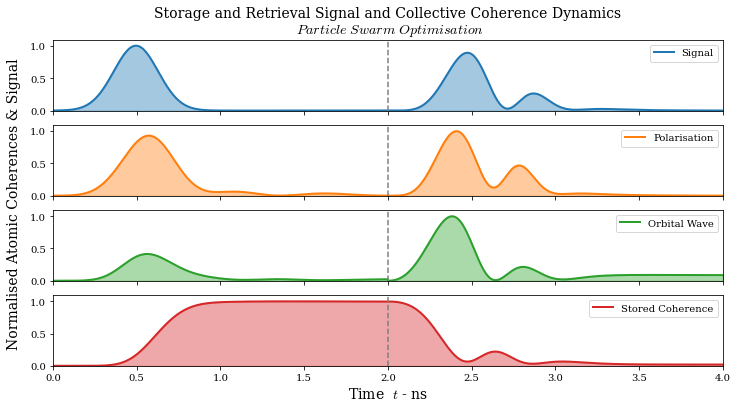

In [80]:
import seaborn as sns

S_total = np.concatenate((S,Sr[:,::-1]))
P_total = np.concatenate((P,Pr[:,::-1]))
B_total = np.concatenate((B,Br[:,::-1]))
R_total = np.concatenate((R,Rr[:,::-1]))

T_total_list = np.linspace(0, 4, tsteps*2)

fig = plt.figure(1)

ax4 = plt.subplot(414)
plt.plot(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), 'C3', linewidth =2, label="Stored Coherence")
plt.fill_between(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), color="C3", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.xlabel("Time  $t$ - ns", fontsize = 14)
#fig.supylabel("Normalised Atomic Coherences & Signal", fontsize = 14)
fig.text(0.08, 0.5, "Normalised Atomic Coherences & Signal", fontsize = 14, ha='center', va='center', rotation='vertical')

ax1 = plt.subplot(411, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(S_total)[0])**2, 'C0', linewidth =2, label="Signal")
plt.fill_between(T_total_list, np.abs(np.transpose(S_total)[0])**2, color="C0", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)
plt.title("Storage and Retrieval Signal and Collective Coherence Dynamics\n $Particle \ Swarm \ Optimisation$", fontsize = 14)

ax2 = plt.subplot(412, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), 'C1', linewidth =2, label="Polarisation")
plt.fill_between(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), color="C1", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(413, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), 'C2', linewidth =2, label="Orbital Wave")
plt.fill_between(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), color="C2", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)

plt.savefig("pso-gauss-dynamics.png", dpi=1200)


# Particle Swarm Optimisation - Arbitrary Pulse Shape - DFT Method

### STORAGE

#### Re-initialise atomic coherences and signal photon

In [225]:
P, B, R = init_coherences(Zlist, Tlist)  # initialise coherences 

tws = 0.440; t0s = 2.25*tws/2;
S = init_signal(Zlist, Tlist, 'gaussian', t0s, tws)  # initialise signal field

#### Define optimisation hyper-parameters

In [226]:
pop = 12 # particle population
iterations = 1000

freq = np.fft.rfftfreq(ttlist.shape[-1], d=1); nvar = len(freq) # Frequency range
Oc_max = 3*np.pi  # Max control Rabi frequency
w = 0.72984  # Inertia
c1 = 2.05  # Cognitive
c2 = 2.05  # Social
fpt = 12  # filter point

#### Run particle swarm optimisation algorithm

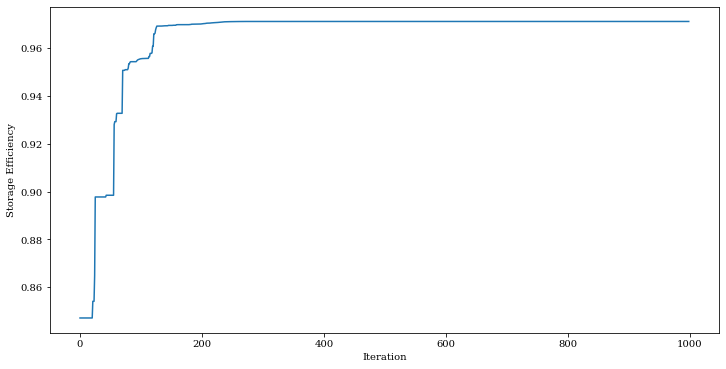

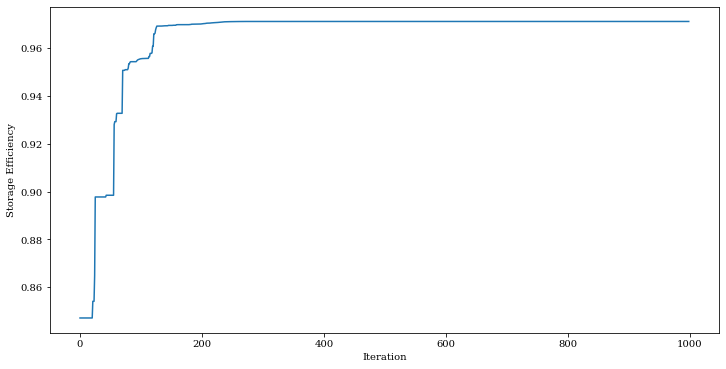

In [227]:
# particles[individual][iteration][position, velocity, fitness]
particles = np.array([[[np.zeros(nvar*2), np.zeros(nvar*2), 0.] for n in range(iterations)] for p in range(pop)], dtype = 'object')
for particle in particles:
    particle[0][0][:int(nvar)] = np.fft.rfft(gaussian(ttlist, np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max))
    particle[0][0][int(nvar):] = np.fft.rfft(gaussian(ttlist, np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max))
    particle[0][1] = np.random.rand(nvar*2)

alphas = []
alphas_positions = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n in range(iterations-1):
    
    w = 0.8 - (0.6/iterations)*n
    c1 = -3*n/iterations + 3.5
    c2 = 3*n/iterations + 0.5
    
    global_bests = np.array([[np.zeros(nvar), 0.] for p in range(pop)], dtype = 'object')
for p in range(pop):
        # compute fitness of each particle in this iteration
        particles[p][n][0][fpt:int(nvar)] = 0
        particles[p][n][0][(int(nvar)+fpt):] = 0
        
        Oct1 = np.abs(np.fft.irfft(particles[p][n][0][:int(nvar)]))**2
        Oct2 = np.abs(np.fft.irfft(particles[p][n][0][int(nvar):]))**2
        
        Oc1_init = np.clip(Oct1, 0, Oc_max)
        Oc2_init = np.clip(Oct2, 0, Oc_max)
        
        Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
        Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')
        
        S, P, B, R = solve(S, P, B, R, Oc1, Oc2)
        particles[p][n][2] = calc_storage_efficiency(S,R)
        
        # for each particle find its best position
        individual_max_indx = np.argmax(particles[p,:,2])
        particle_best = particles[p][individual_max_indx][2]
        particle_best_position = particles[p][individual_max_indx][0]
        # assign to global bests
        global_bests[p][0] = particle_best_position
        global_bests[p][1] = particle_best
    # find the global best and the corresponding position
    global_max_indx = np.argmax(global_bests[:,1])
    global_best = global_bests[global_max_indx, 1]
    global_best_position = global_bests[global_max_indx, 0]
    alphas.append(global_best)
    alphas_positions.append(global_best_position)
    # update plot
    pl.clf()
    pl.plot(range(0,n+1), alphas, 'C0')
    pl.xlabel('Iteration')
    pl.ylabel('Storage Efficiency')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    for p in range(pop):
        # Compute next iteration
        particles[p][n+1][1] = w*np.array(particles[p][n][1]) + c1*np.random.rand()*(np.array(global_bests[p][0]) - np.array(particles[p][n][0])) + c2*np.random.rand()*(np.array(global_best_position) - np.array(particles[p][n][0]))
        particles[p][n+1][0] = np.clip(particles[p][n][0] + particles[p][n+1][1], 0.1, None)


### RETRIEVAL

#### Prepare input to retrieval simulation

In [249]:
fw_test = alphas_positions[-1]

Oct1 = np.abs(np.fft.irfft(fw_test[:int(nvar)]))**2
Oct2 = np.abs(np.fft.irfft(fw_test[int(nvar):]))**2

Oc1_init = np.clip(Oct1, 0, Oc_max)
Oc2_init = np.clip(Oct2, 0, Oc_max)

Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

S,P,B,R = solve(S,P,B,R,Oc1,Oc2)


#### Define retrieval optimisation hyper-parameters

In [250]:
pop = 12 # particle population
iterations = 1000

freq = np.fft.rfftfreq(ttlist.shape[-1], d=1); nvar = len(freq) # Frequency range
Ocr_max = 3*np.pi  # Max control Rabi frequency
w = 0.72984  # Inertia
c1 = 2.05  # Cognitive
c2 = 2.05  # Social
fpt = 12  # filter point

#### Run retrieval particle swarm optimisation algorithm

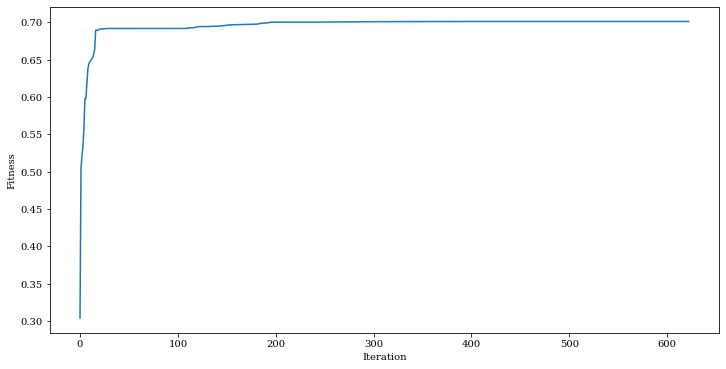

KeyboardInterrupt: 

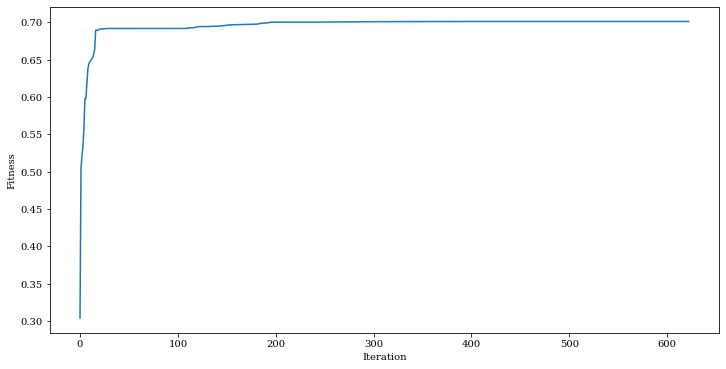

In [251]:
# particles[individual][iteration][position, velocity, fitness]
particles = np.array([[[np.zeros(nvar*2), np.zeros(nvar*2), 0.] for n in range(iterations)] for p in range(pop)], dtype = 'object')
for particle in particles:
    particle[0][0][:int(nvar)] = np.fft.rfft(gaussian(ttlist, np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max))
    particle[0][0][int(nvar):] = np.fft.rfft(gaussian(ttlist, np.random.rand()*T, np.random.rand()*T, np.random.rand()*Oc_max))
    particle[0][1] = np.random.rand(nvar*2)

alphasr = []
alphas_positionsr = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n in range(iterations-1):
    
    w = 0.8 - (0.6/iterations)*n
    c1 = -3*n/iterations + 3.5
    c2 = 3*n/iterations + 0.5
    
    global_bests = np.array([[np.zeros(nvar), 0.] for p in range(pop)], dtype = 'object')
    for p in range(pop):
        # compute fitness of each particle in this iteration
        particles[p][n][0][fpt:int(nvar)] = 0
        particles[p][n][0][(int(nvar)+fpt):] = 0
        
        Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'reverse')
        
        Oct1 = np.abs(np.fft.irfft(particles[p][n][0][:int(nvar)]))**2
        Oct2 = np.abs(np.fft.irfft(particles[p][n][0][int(nvar):]))**2
        
        Oc1_init = np.clip(Oct1, 0, Ocr_max)
        Oc2_init = np.clip(Oct2, 0, Ocr_max)
        
        Ocr1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
        Ocr2 = init_control(Oc2_init, Zlist, Tlist, 'backward')
        
        Sr, Pr, Br, Rr = solve(Sr, Pr, Br, Rr, Ocr1, Ocr2)
        particles[p][n][2] = calc_total_efficiency(Sr,Rr)*calc_overlap(np.abs(Sr.transpose()[-1])**2, np.abs(S.transpose()[0])**2)
        
        # for each particle find its best position
        individual_max_indx = np.argmax(particles[p,:,2])
        particle_best = particles[p][individual_max_indx][2]
        particle_best_position = particles[p][individual_max_indx][0]
        # assign to global bests
        global_bests[p][0] = particle_best_position
        global_bests[p][1] = particle_best
    # find the global best and the corresponding position
    global_max_indx = np.argmax(global_bests[:,1])
    global_best = global_bests[global_max_indx, 1]
    global_best_position = global_bests[global_max_indx, 0]
    alphasr.append(global_best)
    alphas_positionsr.append(global_best_position)
    # update plot
    pl.clf()
    pl.plot(range(0,n+1), alphasr, 'C0')
    pl.xlabel('Iteration')
    pl.ylabel('Fitness')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    for p in range(pop):
        # Compute next iteration
        particles[p][n+1][1] = w*np.array(particles[p][n][1]) + c1*np.random.rand()*(np.array(global_bests[p][0]) - np.array(particles[p][n][0])) + c2*np.random.rand()*(np.array(global_best_position) - np.array(particles[p][n][0]))
        particles[p][n+1][0] = np.clip(particles[p][n][0] + particles[p][n+1][1], 0.1, None)


## Checking the Results

### Storage - Control Pulse and Storage Efficiency

Storage Efficiency:  0.9710919555325902


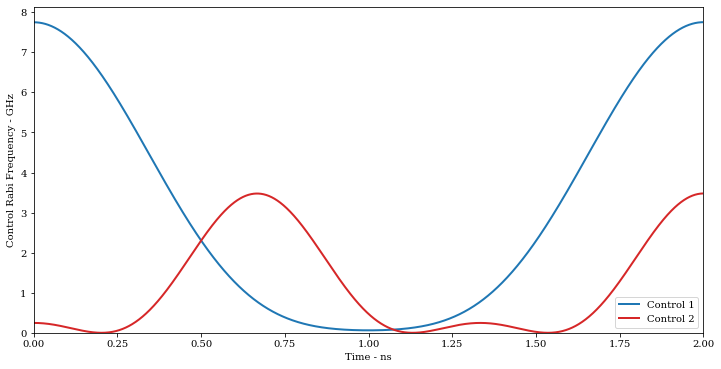

In [234]:
fw_test = alphas_positions[-1]

Oc1_init = np.abs(np.fft.irfft(fw_test[:int(nvar)]))**2
Oc1_init = np.clip(Oc1_init, 0, Oc_max)

Oc2_init = np.abs(np.fft.irfft(fw_test[int(nvar):]))**2
Oc2_init = np.clip(Oc2_init, 0, Oc_max)

plt.plot(ttlist, Oc1_init, linewidth = 2, color='C0', label="Control 1")
plt.plot(ttlist, Oc2_init, linewidth = 2, color='C3', label="Control 2")
plt.xlim([0,2])
plt.ylim([0, None])
plt.xlabel("Time - ns")
plt.ylabel("Control Rabi Frequency - GHz")
plt.legend()

Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

S,P,B,R = solve(S,P,B,R,Oc1,Oc2)

eff = calc_storage_efficiency(S,R)
print("Storage Efficiency: ", eff)

fileName1 = "storage-control-pulse-1-1000it-%d.csv" % int(time.time())
pd.DataFrame(Oc1_init).to_csv(fileName1)
fileName2 = "storage-control-pulse-2-1000it-%d.csv" % int(time.time())
pd.DataFrame(Oc2_init).to_csv(fileName2)

### Retrieval - Control Pulse and Memory Efficiency

Total Memory Efficiency:  0.9279824929693649


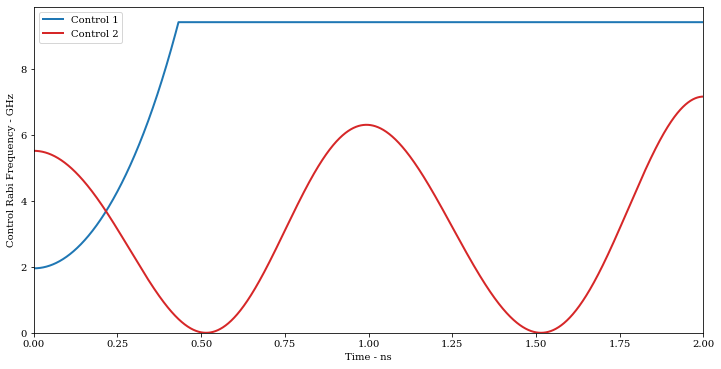

In [235]:
fw_test = alphas_positionsr[-2]

Oct1 = np.abs(np.fft.irfft(fw_test[:int(nvar)]))**2
Oc1_init = np.clip(Oct1, 0, Ocr_max)

Oct2 = np.abs(np.fft.irfft(fw_test[int(nvar):]))**2
Oc2_init = np.clip(Oct2, 0, Ocr_max)

plt.plot(ttlist, Oc1_init, linewidth = 2, color='C0', label="Control 1")
plt.plot(ttlist, Oc2_init, linewidth = 2, color='C3', label="Control 2")
plt.xlim([0,2])
plt.ylim([0, None])
plt.xlabel("Time - ns")
plt.ylabel("Control Rabi Frequency - GHz")
plt.legend()

Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'reverse')

Ocr1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Ocr2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

Sr,Pr,Br,Rr = solve(Sr,Pr,Br,Rr,Ocr1,Ocr2)

eff = calc_total_efficiency(Sr,Rr)
print("Total Memory Efficiency: ", eff)

fileName1 = "retrieval-control-pulse-1-1000it-%d.csv" % int(time.time())
pd.DataFrame(Oc1_init).to_csv(fileName1)
fileName2 = "retrieval-control-pulse-2-1000it-%d.csv" % int(time.time())
pd.DataFrame(Oc2_init).to_csv(fileName2)

### Input and Output Signal Photon Comparison

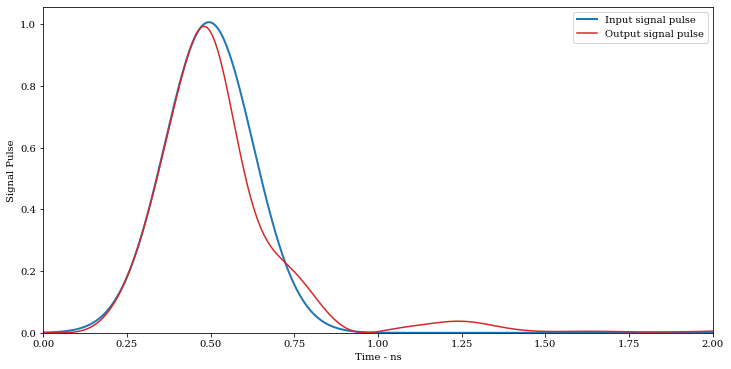

In [236]:
plt.plot(Tlist, np.abs(S.transpose()[0])**2, label="Input signal pulse", linewidth =2, color = "C0")
plt.plot(Tlist, np.abs(Sr.transpose()[-1])**2, label="Output signal pulse", color = "C3")
plt.xlim([0,2])
plt.ylim([0,None])
plt.xlabel("Time - ns")
plt.ylabel("Signal Pulse")
plt.legend()

#### Tracking Progress

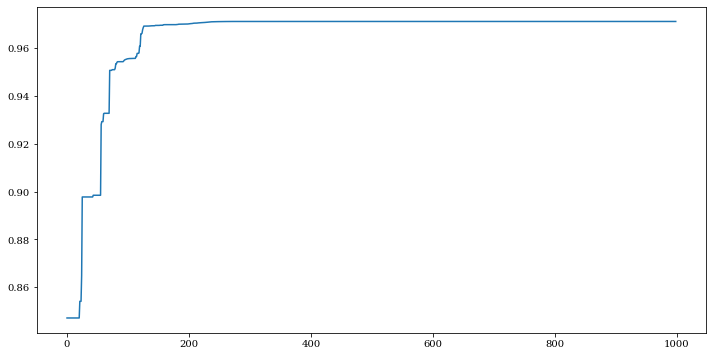

In [237]:
# Storage

plt.plot(range(0,iterations-1), alphas)

fileName = "storage-efficiency-progress-1000it-%d.csv" % int(time.time())
pd.DataFrame(alphas).to_csv(fileName)

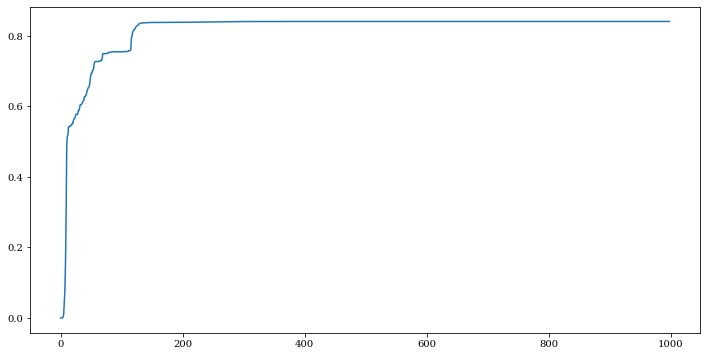

In [239]:
# Retrieval

plt.plot(range(0,iterations-1), alphasr)

fileName = "retrieval-efficiency-progress-1000it-%d.csv" % int(time.time())
pd.DataFrame(alphasr).to_csv(fileName)